
## Accessing NOAA HRRR data on Azure

The NOAA [HRRR](https://www.nco.ncep.noaa.gov/pmb/products/hrrr/) is a real-time 3km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation. 

This notebook provides an example of accessing HRRR data from blob storage on Azure, including (1) finding the data file corresponding to a date and time, (2) retrieving a portion of that file from blob storage which includes the surface temperature variable, (3) opening the file using the `xarray` library, and (4) rendering an image of the forecast.

This dataset is stored in the East US Azure region, so this notebook will run most efficiently on Azure compute located in the same region. If you are using this data for environmental science applications, consider applying for an AI for Earth grant to support your compute requirements.

This dataset is documented at <http://aka.ms/ai4edata-hrrr>.

### Setup the environment

We're using `xarray` with the `cfgrib` engine to open the GRIB2 data into an Dataset. `cfgrib` has some binary dependencies so it's [easiest to install](https://github.com/ecmwf/cfgrib) with Conda. File download is handled with `requests`.

In [48]:
from datetime import date, timedelta
import xarray as xr
import requests

### Assemble the URL for a forecast

HRRR model data are in files named by date and sector (either CONUS or Alaska). We'll load up yesterday's 2D surface levels model forecast for CONUS run at 12pm UTC. The URL will be assembled based on the path parameters [outlined in the documentation](https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources). 

In [60]:
# Constants for creating the full URL
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus"
yesterday = date.today() - timedelta(days=1)
cycle = 12 # noon
forecast_hour = 1
product = "wrfscfc" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"
print(url)


https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20210512/conus/hrrr.t12z.wrfscfc01.grib2


### Determine subsection of our variable

The GRIB2 file format stacks binary representations of 2D arrays after a header. This means that instead of downloading and opening the whole file of 170+ variables (150mb+), we could read from a byte offset of just a single variable (or several). The NOAA HRRR data comes with a sidecar index file that specifies start-byte positions for each variable. These files are the same as the HRRR file, suffixed with `.idx`. Let's use this to calculate the offset of the variable we want.

In [2]:
ds = xr.open_dataset('./tmp.grib2', engine='cfgrib',
                backend_kwargs={'indexpath':''})
ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: x, y
Data variables:
    t           (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-05-13T14:49 GRIB to CDM+CF via cfgrib-0.9.9...

(array([4.57000e+02, 6.91200e+03, 1.03964e+05, 3.02463e+05, 4.71168e+05,
        3.77466e+05, 3.08149e+05, 2.64471e+05, 6.09780e+04, 9.11300e+03]),
 array([263.81607, 268.75357, 273.69107, 278.62857, 283.56607, 288.50357,
        293.44107, 298.37857, 303.31607, 308.25357, 313.19107],
       dtype=float32),
 <BarContainer object of 10 artists>)

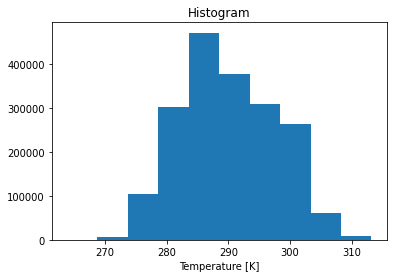

In [3]:
ds.t.plot.hist()

### Define the map projection
The data is in the Lambert Conformal projection. Create a CCRS specification from the attributes in the dataset.
See [this example](https://github.com/blaylockbk/HRRR_archive_download/blob/4105f21ee01ad5a915d9545008fad94cf8af8213/herbie/accessors.py#L69-L78) for more information.

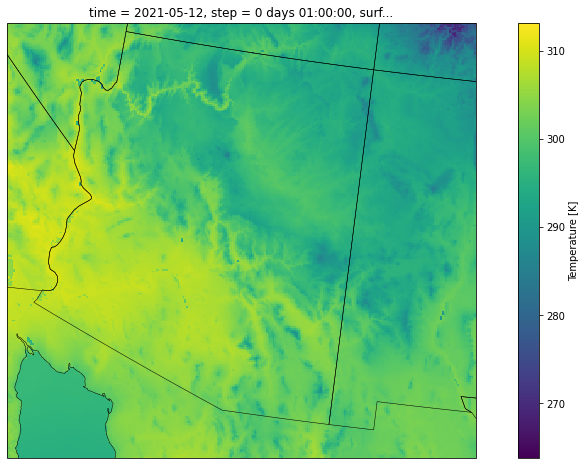

In [40]:
import cartopy.crs as ccrs


attrs = ds.t.attrs

prj_kwargs = dict(
    globe=ccrs.Globe(ellipse='sphere'),
    central_latitude=attrs['GRIB_LaDInDegrees'],
    central_longitude=attrs['GRIB_LoVInDegrees'],
    standard_parallels=(attrs['GRIB_Latin1InDegrees'],\
                        attrs['GRIB_Latin2InDegrees'])
)
prj = ccrs.LambertConformal(**lc_kwargs)

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


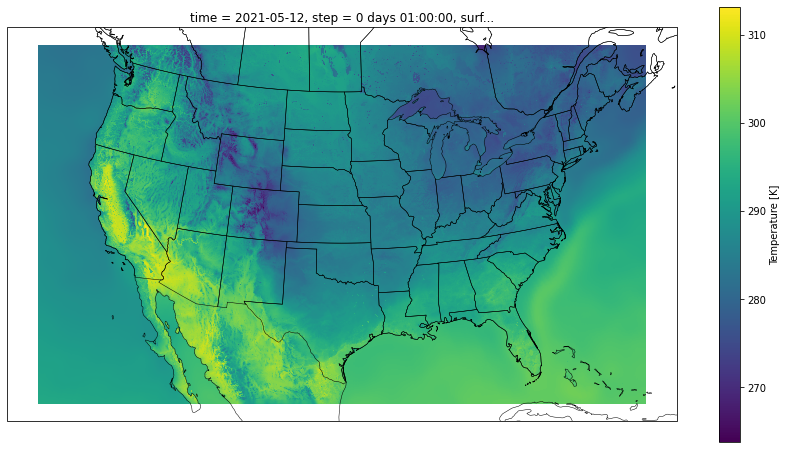

In [44]:
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
ds.t.plot(x='longitude', y='latitude', 
          ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)


In [41]:

#ax.set_extent([-115, -107, 31, 37], crs=ccrs.PlateCarree())

ValueError: dimensions or multi-index levels ['latitude', 'longitude'] do not exist

<xarray.DataArray 'y' (y: 1059)>
array([   0,    1,    2, ..., 1056, 1057, 1058])
Coordinates:
    time        datetime64[ns] 2021-05-12
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2021-05-12T01:00:00
Dimensions without coordinates: y